# Near Earth Objects

This project is meant to analyze the data of Near Earth Objects, and build a classifier that can determine whether or not a specific near earth object observation is hazardous to earth. The data set can be found here: 

https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects?select=neo_v2.csv


It is also meant to test different machine learning algorithms to learn which is optimal for this use case.

libraries and modules:

In [1]:
%pip install tensorflow
%pip install mlxtend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.preprocessing import minmax_scaling

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('archive/neo_v2.csv')
pd.set_option('display.max_columns', None)

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Some metrics on the data

In [2]:
df.head(10)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
5,54138696,(2021 GY23),0.036354,0.081291,34297.587778,4.058569e+07,Earth,False,24.32,False
6,54189957,(2021 PY40),0.171615,0.383743,27529.472307,2.906912e+07,Earth,False,20.95,False
7,54230078,(2021 XD6),0.005328,0.011914,57544.470083,5.511502e+07,Earth,False,28.49,False
8,2088213,88213 (2001 AF2),0.350393,0.783502,56625.210122,6.903598e+07,Earth,False,19.40,False
9,3766065,(2016 YM),0.105817,0.236614,48425.840329,3.835526e+07,Earth,False,22.00,False


In [3]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

There are no missing values. It appears that the id is a unique identifier for a near earth object, but there are far less unique id's than unique data points. This must mean that datapoints in this dataset refer to observations of NEO's and there may be multiple observations on the same object.

## Data Visualization

Let's start off by vizualizing my data. By plotting the size of the NEO with the absolute magnitude (which is a measure of its luminosity), I see what appears to be a logarithmic trend, which is to be expected since absolute magnitude is a logarithmic scale.

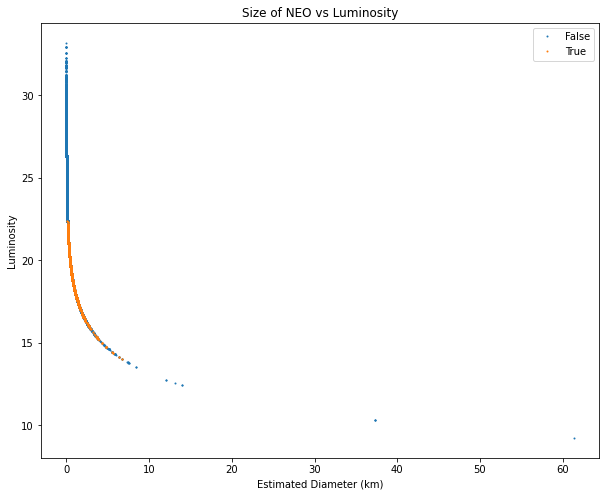

In [4]:
groups = df.groupby('hazardous')
plt.figure(figsize=(10, 8))
for name, group in groups:
    plt.plot(
        (group['est_diameter_max']+group['est_diameter_min'])/2, 
        group['absolute_magnitude'], 
        marker='.', 
        linestyle='', 
        markersize=2, 
        label=name
    )
plt.legend()
plt.xlabel('Estimated Diameter (km)')
plt.ylabel('Luminosity')
plt.title('Size of NEO vs Luminosity')
plt.show()

Taking the log of the diameter gives a linear graph

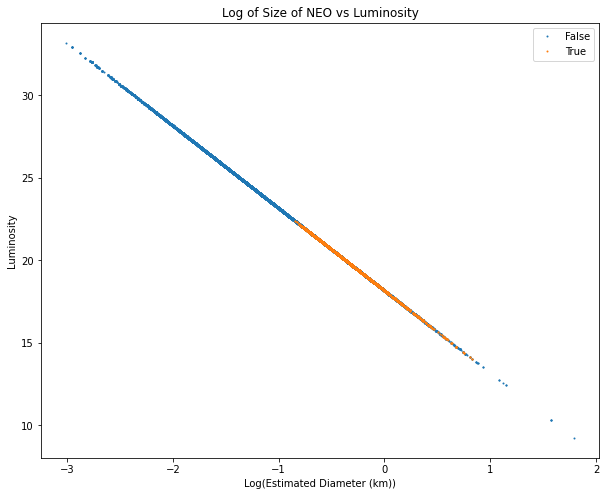

In [5]:
groups = df.groupby('hazardous')
plt.figure(figsize=(10, 8))
for name, group in groups:
    plt.plot(
        np.log10((group['est_diameter_max']+group['est_diameter_min'])/2), 
        group['absolute_magnitude'], 
        marker='.', 
        linestyle='', 
        markersize=2, 
        label=name
    )
plt.legend()
plt.xlabel('Log(Estimated Diameter (km))')
plt.ylabel('Luminosity')
plt.title('Log of Size of NEO vs Luminosity')
plt.show()

From this, we are able to deduce two things. 

Firstly, there is a very strong correlation between the luminosity and the log of the diameter, as the deviation from line of best fit is very small. This makes sense since as long as NEO's have similar reflectivity, their luminosity is from reflection of the sun, thus the only variable is their surface area. (note that low absolute magnitude means brighter). It makes sense that the largest NEO's are the brightest.

Also, all hazardous NEO observations fall under a specific range of diameter (and a range of luminosity). This range seems to be from 100 meters to 10 kilometers. 

This matches intuition as, from NASA's page on asteroids *(1)* states, rocks smaller than 25 meters burn up entirely in the atmosphere. It is feasible that rocks below 100 meters would be reduced in size to an extent that impact on earth would cause minimal damage.

There are relatively few NEO's larger than 10km diameter, and of them, none are hazardous. 

Next, we observe the Luminosity plotted against Relative Velocity.

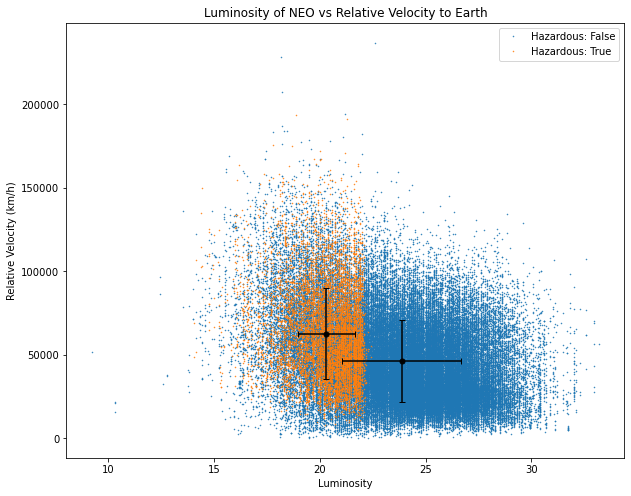

In [6]:
groups = df.groupby('hazardous')
plt.figure(figsize=(10, 8))
# plot
for name, group in groups:
    x = group['absolute_magnitude']
    y = group['relative_velocity']
    plt.plot(
        x, 
        y, 
        marker='.', 
        linestyle='', 
        markersize=1, 
        label=f'Hazardous: {name}'
    )
# mean and std
for name, group in groups:
    x = group['absolute_magnitude']
    y = group['relative_velocity']
    plt.plot(
        x.mean(), 
        y.mean(), 
        marker='o', 
        linestyle='', 
        markersize=5, 
        color="k"
    )
    plt.errorbar(
        x.mean(), 
        y.mean(), 
        yerr=y.std(),
        xerr=x.std(),
        capsize=3,
        ls='-.',
        color='k'
    )
plt.legend()
plt.xlabel('Luminosity')
plt.ylabel('Relative Velocity (km/h)')
plt.title('Luminosity of NEO vs Relative Velocity to Earth')
plt.show()

- There is a shear cutoff of hazardous NEO observations based on Luminosity, which was also observed in the previous plot.

- NEO observations with lower absolute value (brighter NEO's) appear to have a higher variance of relative velocity

- Hazardous NEO observations appear to have a higher mean relative velocity than non hazardous NEO observations

Moving on to plotting luminosity and the log of miss distance:

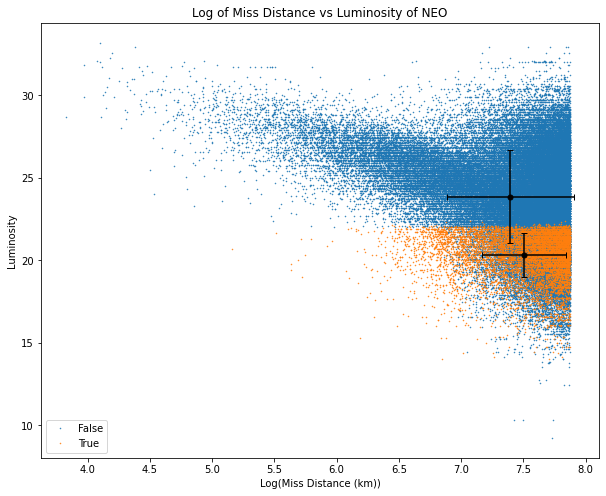

In [7]:
groups = df.groupby('hazardous')
plt.figure(figsize=(10, 8))
# plot
for name, group in groups:
    x = np.log10(group['miss_distance'])
    y = group['absolute_magnitude']
    plt.plot(
        x, 
        y, 
        marker='.', 
        linestyle='', 
        markersize=1, 
        label=name
    )
# mean and std
for name, group in groups:
    x = np.log10(group['miss_distance'])
    y = group['absolute_magnitude']
    plt.plot(
        x.mean(), 
        y.mean(), 
        marker='o', 
        linestyle='', 
        markersize=5, 
        color="k"
    )
    plt.errorbar(
        x.mean(), 
        y.mean(), 
        yerr=y.std(),
        xerr=x.std(),
        capsize=3,
        ls='-.',
        color='k'
    )
plt.legend()
plt.xlabel('Log(Miss Distance (km))')
plt.ylabel('Luminosity')
plt.title('Log of Miss Distance vs Luminosity of NEO')
plt.show()

- Here again, we see the distinctive band of luminosity that all hazardous NEO observations reside. 

- There is a disproportionately large collection of NEO observations with Luminosity > 23 with a closer miss distance (1e4km to 1e6km), all of which are not hazardous

- Most hazardous NEO observations have a miss distance between 5-100 million km, with a smaller variance and a larger mean miss distance than non hazardous NEO observations.

Note that since Luminosity and the log of the diameter have a linear relationship, the plots for log(diameter) vs log(miss distance), and log(diameter) vs. relative velocity will show the same trends. 

Thus far, for diameter plots, I have been using the mean of est_diameter_min and est_diameter_max. Perhaps its worthwhile to see the relation between these values

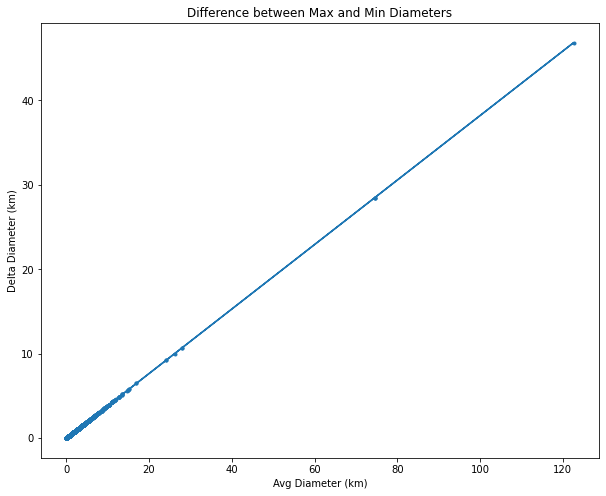

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(
    (df['est_diameter_max']+df['est_diameter_min']),
    (df['est_diameter_max']-df['est_diameter_min']),
    marker='.', 
    linestyle='-'
)
plt.xlabel('Avg Diameter (km)')
plt.ylabel('Delta Diameter (km)')
plt.title('Difference between Max and Min Diameters')
plt.show()

As we see, the delta between the max and min recorded diameters increases linearly with the average diameter. This means that we may safely use just one of these values (say the max diameter) and the only thing that would be affected is the scaling factor 

## Investigation

The first thing I wish to investigate is the relationship between hazardous NEO observations, and individual objects. I start by finding the number of times a specific NEO was observed, and the number of times the NEO was classified as hazardous. I then find the ratio of the sum of times an NEO was considered hazardous, and the total number of times it was observed. 

In [9]:
df['hazardous_int'] = df['hazardous'].astype(int)
df['prev_hazard_sum'] = df.groupby('id')['hazardous_int'].transform('sum')
df['times_observed'] = df.groupby('id')['id'].transform('count')
df['hazard_ratio'] = df['prev_hazard_sum'] / df['times_observed']
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous,hazardous_int,prev_hazard_sum,times_observed,hazard_ratio
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False,0,0,1,0.0
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True,1,24,24,1.0
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False,0,0,7,0.0
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False,0,0,7,0.0
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True,1,2,2,1.0


In [10]:
df['hazard_ratio'].nunique()

2

As I somewhat suspected, there are only 2 unique values for this ratio, either 1 or 0, meaning that if a single observation concluded the NEO was hazardous, all subsequent observations will conclude the same. 

The next thing that would be good knowing is the amount of deviation between multiple observations of a single NEO.

In [11]:
df['relative_velocity_observation_std'] = df.groupby('id')['relative_velocity'].transform('std')
df['miss_distance_observation_std'] = df.groupby('id')['miss_distance'].transform('std')

df.head(10)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous,hazardous_int,prev_hazard_sum,times_observed,hazard_ratio,relative_velocity_observation_std,miss_distance_observation_std
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False,0,0,1,0.0,NaN,NaN
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True,1,24,24,1.0,18086.043450,1.633261e+07
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False,0,0,7,0.0,21538.535099,1.492830e+07
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False,0,0,7,0.0,17530.595700,2.317172e+07
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True,1,2,2,1.0,222.476118,4.494641e+05
5,54138696,(2021 GY23),0.036354,0.081291,34297.587778,4.058569e+07,Earth,False,24.32,False,0,0,16,0.0,15632.197653,1.955787e+07
6,54189957,(2021 PY40),0.171615,0.383743,27529.472307,2.906912e+07,Earth,False,20.95,False,0,0,5,0.0,18048.505495,2.122332e+07
7,54230078,(2021 XD6),0.005328,0.011914,57544.470083,5.511502e+07,Earth,False,28.49,False,0,0,7,0.0,19493.698866,1.795295e+07
8,2088213,88213 (2001 AF2),0.350393,0.783502,56625.210122,6.903598e+07,Earth,False,19.40,False,0,0,9,0.0,24694.460444,1.460467e+07
9,3766065,(2016 YM),0.105817,0.236614,48425.840329,3.835526e+07,Earth,False,22.00,False,0,0,6,0.0,4884.966709,1.362220e+07


As it appears that deviation between measurements of a single NEO are the same order of magnitude of the measurements themselves, for both hazardous and non hazardous NEO's, it doesn't seem likely that this would be a major determining factor

Since relative velocity and miss distance have very large values, it would be beneficial to scale them

In [12]:
df['scaled_relative_velocity'] = minmax_scaling(df['relative_velocity'] , columns=[0])
df['scaled_miss_distance'] = minmax_scaling(df['miss_distance'] , columns=[0])

/opt/anaconda3/lib/python3.9/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]
/opt/anaconda3/lib/python3.9/site-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


I then add all the columns I intend to use in the model to its own dataframe, and define the training parameters. Note that since there is such a large correlation between diameter and absolute magnitude, I concluded I could safely emit one of them.

I also created a testing set that is perfectly balanced between hazardous and non hazardous NEO's to better test the effectiveness of the model

In [13]:
model_df = df[[
    'scaled_relative_velocity', 
    'scaled_miss_distance', 
    'absolute_magnitude', 
    'hazardous'
]]

balanced_test_df = df.loc[df['hazardous'] == True].iloc[:8000].append(
    df.loc[df['hazardous'] == False].iloc[:8000]
)
balanced_test_df = balanced_test_df[[
    'scaled_relative_velocity', 
    'scaled_miss_distance', 
    'absolute_magnitude', 
    'hazardous'
]]

/var/folders/9m/y58zrw4128dfnxt0vkblk35r0000gn/T/ipykernel_33982/909574485.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_test_df = df.loc[df['hazardous'] == True].iloc[:8000].append(


I split the data into training and testing samples

In [14]:
train, test = train_test_split(model_df, test_size=0.2)

x = train.drop(['hazardous'], axis=1)
y = train['hazardous']

x_test = test.drop(['hazardous'], axis=1)
y_test = test['hazardous']

## Neural Network

The first model I would like to test is a sequential neural network

In [15]:
# training parameters
learning_rate = 0.002
decay_rate = 0.1
patience = 20
min_delta = 0.0001
batch_size = 300
epochs = 200

I define a model, with a single hidden layer, and train it on the data.

In [16]:
nn_model = keras.Sequential([
    layers.InputLayer(input_shape=[len(model_df.columns)-1]),  
    layers.Dense(3, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid'),
])
opt = keras.optimizers.Adam(
    learning_rate=learning_rate,
    decay=decay_rate, 
)
nn_model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=patience,
    min_delta=min_delta,
    restore_best_weights=True,
)

2022-07-18 19:53:40.557119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best Validation Loss: 0.5546
Best Validation Accuracy: 0.8993


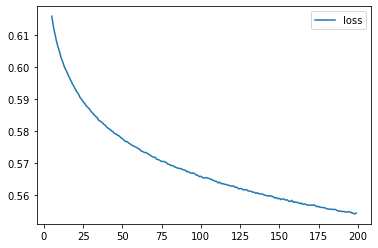

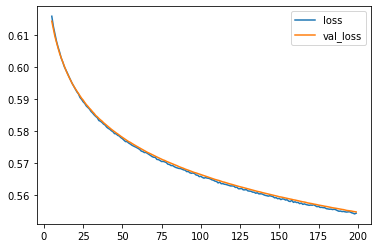

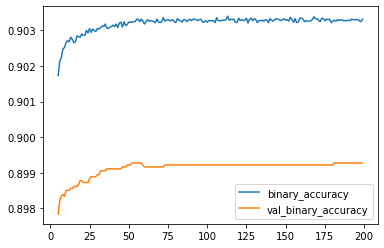

In [17]:
history = nn_model.fit(
    x, y,
    validation_data=(x_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=False
)

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss']].plot()
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

### Results

When training this model, several times the validation accuracy started off at 90.26% after the first epoch, and remained unchanged for the rest of the training process as the validation loss decreased. While promising at first, I quickly realized that the percent of times the model guessed right was exactly the proportion of entries in the dataset where hazardous=False. Retesting on a balanced testing set of 50% hazardous=True, and 50% hazardous=False entries revealed a validation accuracy of exactly 50%. This means that my model was just returning false all the time, and being correct 90% of the time. 

Upon careful tweaking of the training parameters, and capacity of the model, I was able to train the model such that the validation accuracy increased throughout training, however training the model several times produced variable results, and it sometimes did still train the model to just return false.

To test that this isn't happening I tested with the set of data that is exactly 50% split. A testing accuracy of over 50% means the model trained as intended.

In [18]:
score = nn_model.evaluate(
    balanced_test_df.drop(['hazardous'], axis=1), 
    balanced_test_df['hazardous'], verbose = False
) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.712462306022644
Test accuracy: 0.5003125071525574


Thus far, I have never been able to get a testing accuracy score with the balanced data as high as the validation accuracy of the original testing data.

## Random Forest

Next is a Random Forest Model

In [19]:
rf_model = RandomForestClassifier()
rf_model.fit(x, y)

y_predicted = rf_model.predict(x_test)
print (f'Unbalanced Testing Score: {100*accuracy_score(y_test, y_predicted)}')

y_predicted_balanced = rf_model.predict(balanced_test_df.drop(['hazardous'], axis=1))
print (f'Balanced Testing Score: {100*accuracy_score(y_predicted_balanced, balanced_test_df["hazardous"])}')

Unbalanced Testing Score: 91.04469396741524
Balanced Testing Score: 92.4875


### Results

Training the model with the original data, and then testing it on both the original unbalanced testing data and the balanced data, we see a very high accuracy score for both.

## Conclusion

The model you choose for your specific solution could have a large impact on your model's accuracy, and a more advanced, complicated model is sometimes not the right pick for your use case. It is always beneficial to know the strengths and limitations of the model you're working with, and try using different models to find the optimal one.

### References:

1. https://www.nasa.gov/mission_pages/asteroids/overview/fastfacts.html